In [3]:
%matplotlib inline
import pandas as pd
import gzip
import numpy as np
from scipy.optimize import minimize
from datetime import timedelta
import tensorflow as tf
from datetime import timedelta
from scipy.sparse import csr_matrix
from dateutil.parser import parse
import json

In [4]:
#inputfile="/home/sathappan/workspace/time2event/hawkes/data/all_trades.csv"
#inputfile="/Users/nikhil/phd/urban_computing/wmata/repos/PointProcess/data/all_trades.csv"
def read_data(inputfile,_e=1.667e-6):
    """
        Read inputfile , process difference between first event and each subsequent event.
        Assumption is that events are in sorted order by datetime.
    """
    
    df = pd.read_csv(inputfile)
    df.t = pd.to_datetime(df.t)
    pp = (df.t - df.t[0]).apply(lambda x: x/np.timedelta64(1, 'm')).value_counts()
    events = []
    e = _e
    for t, cnt in pp.iteritems():
        base_time = t
        for i in range(cnt):
            #here we just add i*e_i (a very small perturbation) to avoid collisions.
            events.append(base_time + e*i)  
    
    events = np.array(sorted(events))
    empirical = df.t
    empirical_counts = empirical.value_counts().resample(rule='1min').sum()
    events = events[None, :]   #None operation adds an extra dimention of size 1 to events.
    return events,empirical_counts


In [70]:
inputfile="/Users/nikhil/phd/urban_computing/wmata/repos/PointProcess/data/all_trades.csv"
events_all,empirical_counts_all=read_data(inputfile)

array([[  0.00000000e+00,   1.66700000e-06,   2.50000000e-01, ...,
          4.05966667e+02,   4.06000000e+02,   4.06000002e+02]])

In [40]:
def calc_Ai(arrivals, mask, beta):
    tdiff = np.diff(arrivals) * mask[:, 1:]
    tdiff = np.exp(tdiff * -beta)
    A_i = np.zeros_like(arrivals, dtype=np.float128)
    for i in range(tdiff.shape[1]):
        #print(i,)
        A_i[:, i + 1] = tdiff[:, i] * (1 + A_i[:, i])
    return A_i, tdiff

In [41]:
#A_i, tempdiff = calc_Ai(events, mask, 1.0)

In [42]:
def calc_temporal_differences(arrivals, mask):
    #U X T X T tensor.
    temporal_diff = np.zeros((arrivals.shape[0], arrivals.shape[1], arrivals.shape[1]))
    #mask_tempdiff = np.zeros_like(temporal_diff)
    for t_i in range(arrivals.shape[1]):
        temporal_diff[:, :t_i, t_i] = arrivals[:, t_i] - arrivals[:, :t_i]
        #mask_tempdiff[:, :t_i, t_i] = 1.0
    mask_tempdiff = (temporal_diff != 0) 
    
    return mask_tempdiff, temporal_diff
    ### Create a UsersxTimexTime matrix

In [43]:
mask = np.ones_like(events)
mask_tdiff, temporal_diff = calc_temporal_differences(events, mask)

In [44]:
mask_tdiff[:,:2,:5],temporal_diff[:,:2,:5]

(array([[[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True]]], dtype=bool),
 array([[[  0.00000000e+00,   1.66700000e-06,   2.50000000e-01,
            2.11666667e+00,   2.16666667e+00],
         [  0.00000000e+00,   0.00000000e+00,   2.49998333e-01,
            2.11666500e+00,   2.16666500e+00]]]))

In [45]:
def loglikelihood():
    #tdiff = diff(arrivals) * mask[:, 1:]
    #A_i = tf.zeros_like(arrivals)
    #for i in range(tdiff.shape[0]):
    #    A_i[:, i + 1] = tdiff[:, i] * (1 + A[:, i ])
    #part1 = tf.log(mu + alpha * ais_tvar)
    #part1 = tf.reduce_sum(tf.log(mu + alpha * ais_tvar), axis=1)[:, None]
    hist_effects = tf.reduce_sum((tf.exp(-beta[:, :, None] * temp_diff_tvar))\
                                 *mask_tdiff_tvar, axis=2)
    part1 = tf.reduce_sum(tf.log(mu + alpha * hist_effects), axis=1)
    #part1 = tf.reduce_sum()
    T_max = tf.reduce_max(arrivals_tvar*mask_tvar, axis=1)[:, None]
    part2 = mu * T_max
    tmp = tf.exp(-beta * ((T_max - arrivals_tvar)*mask_tvar))
    p3_tmp = tf.reduce_sum(tmp - tf.constant(1.0, dtype=tf.float64), axis=1)
    part3 = (alpha / beta)* p3_tmp[:, None]
    
    #return part1, part2, part3, part1 - part2 + part3
    return tf.reduce_sum(part1 - part2 + part3)

In [46]:
mask.shape,mask_tdiff.shape

((1, 5000), (1, 5000, 5000))

In [47]:
num_users = 1
alpha = tf.Variable(tf.random_uniform([num_users, 1], dtype=tf.float64), name='alpha')
beta = tf.Variable(tf.random_uniform([num_users, 1], dtype=tf.float64), name='beta')
mu = tf.Variable(tf.random_uniform([num_users, 1], dtype=tf.float64), name='mu')

In [48]:
#T_max = 5000
T_max = mask_tdiff.shape[1] 
arrivals_tvar = tf.placeholder(tf.float64, [None, T_max])
mask_tvar = tf.placeholder(tf.float64, [None, T_max])
temp_diff_tvar = tf.placeholder(tf.float64,[None, T_max, T_max])
mask_tdiff_tvar = tf.placeholder(tf.float64, [None, T_max, T_max])

In [49]:
def cost_func():
    conv=0.4
    nloglik = -loglikelihood()
    #regularizer = tf.reduce_sum(alpha)  + tf.reduce_sum(mu) + tf.reduce_sum(alpha/beta) 
    regularizer = tf.reduce_sum(alpha)+tf.reduce_sum(mu)+tf.reduce_sum(beta) +\
    tf.reduce_sum(tf.square(alpha))+tf.reduce_sum(tf.square(beta))+tf.reduce_sum(tf.square(mu))#-tf.reduce_sum(tf.abs(alpha))-tf.reduce_sum(tf.abs(beta))
    return (1-conv)*regularizer + (conv)*nloglik

In [50]:
#p3 = loglikelihood()
p3 = cost_func()
#grad = tf.gradients(p3, [alpha, beta, mu])

optim = tf.train.GradientDescentOptimizer(0.000001).minimize(p3)
#clip_alpha = alpha.assign(tf.maximum(0.05, alpha))
#clip_beta = beta.assign(tf.maximum(0.05, beta))

#commented_nikhil
#gr_alpha, gr_beta, gr_mu  = optim.compute_gradients(p3)

In [51]:
# gr_alpha = (tf.clip_by_value(gr_alpha[0], 0.01, np.infty), gr_alpha[1])
# gr_beta = (tf.clip_by_value(gr_beta[0], 0.01, np.infty), gr_beta[1])
# gr_mu = (tf.clip_by_value(gr_mu[0], 0.01, np.infty), gr_mu[1])

#commented_nikhil_start
#minmzr = optim.apply_gradients([gr_alpha,gr_beta, gr_mu])
#commented_nikhil_end

#p1, p2, p3 = loglikelihood()
#capped_gvs = [(tf.clip_by_value(grad, 0, 1), var) for grad, var in gvs]
#train_op = optim.apply_gradients(capped_gvs)

In [52]:
#np.random.seed(12345)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    #print("Initial Value of alpha, beta and gamma", gr_alpha[1].eval(),gr_beta[1].eval(),gr_mu[1].eval())
    _cost=list()
    _alphas=list()
    _betas=list()
    _mus=list()
    print("Initial Vals","alpha",alpha.eval(),"beta",beta.eval())
    #tf_a = (sess.run([gr_alpha, minmzr], feed_dict={arrivals_tvar: np.nan_to_num(arrivals_numpy), mask_tvar:mask, ais_tvar:A_i, tdiff_tvar: tempdiff}))
    for i in range(50):
#         _, c, al, bt,m = (sess.run([minmzr, p3, alpha, beta, mu], \
#                                    feed_dict={arrivals_tvar: np.nan_to_num(events),\
#                                               mask_tvar:mask, temp_diff_tvar: temporal_diff,\
#                                               mask_tdiff_tvar:mask_tdiff}))
        op,c,al,bt,m=(sess.run([optim,p3,alpha,beta,mu],feed_dict={arrivals_tvar: np.nan_to_num(events),\
                                   mask_tvar:mask, temp_diff_tvar: temporal_diff,\
                                   mask_tdiff_tvar:mask_tdiff}))
        if not (i%50):
            print("Iter ",i,"cost",c,"al",al,"bt",bt,"m",m)
        _cost.append(c)
        _betas.append(bt)
        _alphas.append(al)
#         if alpha.eval()<0 or alpha.eval()>100:
#             print("Iter ",i,"Before Clipping Alpha",alpha.eval())
#             val=tf.stack(np.random.random(alpha.get_shape()))
#             alpha=tf.assign(alpha,val)
#             print("After Clipping Alpha",alpha.eval())

#         if beta.eval()<0 or beta.eval()>100:
#             print("Iter ",i,"Before Clipping Beta",beta.eval())
            
#             val=tf.stack(np.random.random(beta.get_shape()))
#             beta=tf.assign(beta,val)
#             print("After Clipping Beta",beta.eval())
        if not (i % 50):
            #print(c)
            #print(al, bt, m)
            pass
    #tf_a, tf_b, tf_c, tf_d = (sess.run(p3, feed_dict={arrivals_tvar: np.nan_to_num(arrivals_numpy), mask_tvar:mask, ais_tvar:A_i, tdiff_tvar: tempdiff}))

Initial Vals alpha [[ 0.52438132]] beta [[ 0.80436675]]
Iter  0 cost -3747.87112142 al [[ 0.52544214]] bt [[ 0.80400995]] m [[ 0.65586428]]


KeyboardInterrupt: 

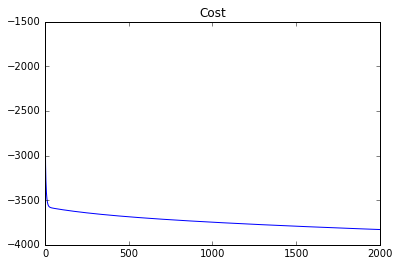

In [17]:
import matplotlib.pyplot as plt
plt.plot(_cost)
plt.title("Cost")

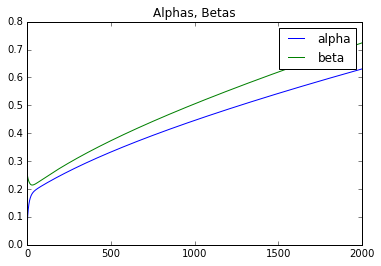

In [18]:
plt.plot([val[0][0] for val in _alphas])
plt.plot([val[0][0] for val in _betas])
plt.title("Alphas, Betas")
plt.legend(["alpha","beta"])

In [21]:
#cd ..

/Users/nikhil/phd/urban_computing/wmata/repos


In [66]:
mu=0.99304723
alpha=0.6218229
beta=0.71359743

def visualize_fit(alpha,beta,mu):
    from PointProcess.hawkes import UniVariateHawkes
    u = UniVariateHawkes()
    compensators = u.calc_compensator(mu, alpha, beta, np.arange(events.shape[1]), events)
    timepoints = np.linspace(int(events.min()), int(events.max()), events.shape[1])
    cif = u.calc_conditionIntensity(mu, alpha, beta, timepoints, events)
    plt.figure(figsize=(20,5))
    plt.plot(timepoints, cif)
    plt.plot(range(407), empirical_counts.values, alpha=.4)


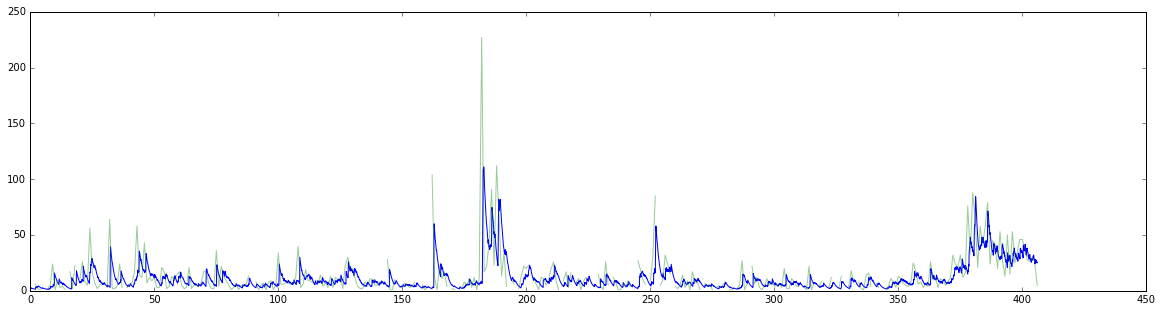

In [67]:
visualize_fit(alpha,beta,mu)

In [68]:
events.shape

(1, 5000)

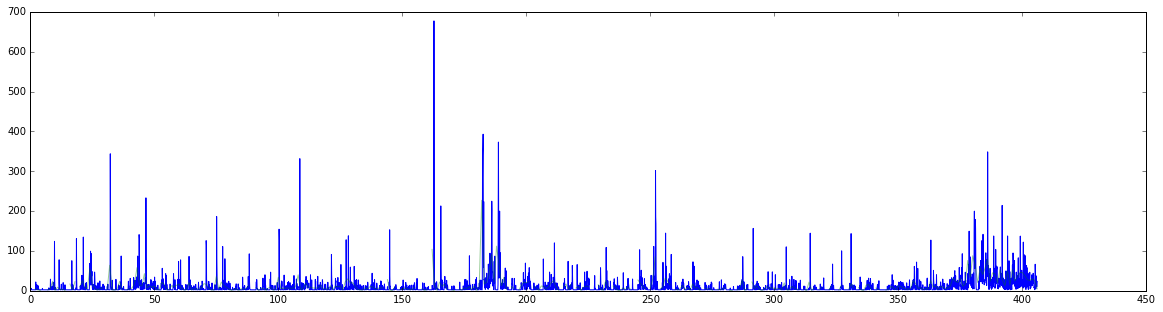

In [69]:
mu=2.52
alpha=13.14
beta=18.15
visualize_fit(alpha,beta,mu)

# compensators = u.calc_compensator(mu, alpha, beta, np.arange(500), events)
# timepoints = np.linspace(int(events.min()), int(events.max()), 100)
# cif = u.calc_conditionIntensity(mu, alpha, beta, timepoints, events)
# plt.figure(figsize=(20,5))
# plt.plot(timepoints, cif)

# plt.plot(range(407), empirical_counts.values, alpha=.4)

In [121]:
import numpy as np
from datetime import datetime as dt

#Testing with WMATA Data
inputfile1="/Users/nikhil/phd/urban_computing/datasets/wmata/wmata_2015_2016/user_timeseries_sorted_100.gz"
inputfile2="/Users/nikhil/phd/urban_computing/wmata/repos/PointProcess/data/all_trades.csv"
#wmata_events,wmata_empirical_counts=read_data(inputfile1)
#bitcoin_events,bitcoin_empirical_counts=read_data(inputfile2)

#We expect event_list to be a series object of value_counts.
def _perturb(event_list,_e=1.667e-4):
    events=list()
    for t, cnt in event_list.iteritems():
        base_time = t
        for i in range(cnt):
            #here we just add i*e_i (a very small perturbation) to avoid collisions.
            events.append(base_time + (_e*i))  
    return events

def read_data_wmata(inputfile,scaletimeunit='h',precision=4,_e=1.667e-6,num_users=10,test_percentage=0.2):
    with gzip.open(inputfile) as f:
        cnt = 0
        user_events_train = list()
        user_events_test=list()
        user_ids= list()
        empirical_counts=list()
        for idx,line in enumerate(f):
            if idx >= num_users:
                break

            _user_events=list()
            _tmp=json.loads(line.decode('utf-8'))
            _user_events=pd.Series(sorted([parse(_dt) for _dt in _tmp['arrivalTimes']]))
                 
            user_ids.append(_tmp['_id'])
            _user_events=((_user_events - _user_events[0]).apply(lambda x:
                        round(x/np.timedelta64(1, scaletimeunit),precision))
                          .value_counts().sort_index())
            all_user_events=_perturb(_user_events)
            train_end_idx=len(all_user_events) - int(len(all_user_events)*test_percentage)
            #print(train_end_idx,len(all_user_events))
            test_user_events=all_user_events[train_end_idx+1:]
            train_user_events=all_user_events[:train_end_idx]
            user_events_train.append(train_user_events)
            user_events_test.append(test_user_events)
            empirical=pd.Series(sorted([parse(_dt) for _dt in _tmp['arrivalTimes']]))
            #print(empirical)
            if scaletimeunit=='m':
                resample_scaletimeunit='T'
            elif scaletimeunit=='h':
                resample_scaletimeunit='h'
            elif scaletimeunit=='D':
                resample_scaletimeunit='D'
            emp_cnt_val=empirical.value_counts().resample(rule=resample_scaletimeunit).sum()
            empirical_counts.append(emp_cnt_val)
            
    user_events_train=pd.DataFrame(user_events_train)
    mask_train = ~(user_events_train.isnull()).as_matrix()
    user_events_test=pd.DataFrame(user_events_test)
    mask_test = ~(user_events_test.isnull()).as_matrix()
    
    return np.nan_to_num(user_events_train.as_matrix()),np.nan_to_num(user_events_test.as_matrix()),mask_train,mask_test,empirical_counts,user_ids


In [133]:
events_train,events_test,mask_train,mask_test,empirical_counts,user_ids=read_data_wmata(inputfile1,scaletimeunit='D',test_percentage=0.2)

In [137]:
events_train[0][:10],empirical_counts[0]

(array([  0.    ,   8.5527,   9.5573,   9.9382,  10.5543,  11.5721,
         11.5993,  12.5179,  12.6871,  15.7633]), 2015-01-03    1.0
 2015-01-04    NaN
 2015-01-05    NaN
 2015-01-06    NaN
 2015-01-07    NaN
 2015-01-08    NaN
 2015-01-09    NaN
 2015-01-10    NaN
 2015-01-11    NaN
 2015-01-12    1.0
 2015-01-13    2.0
 2015-01-14    1.0
 2015-01-15    2.0
 2015-01-16    2.0
 2015-01-17    NaN
 2015-01-18    NaN
 2015-01-19    4.0
 2015-01-20    2.0
 2015-01-21    2.0
 2015-01-22    NaN
 2015-01-23    2.0
 2015-01-24    NaN
 2015-01-25    NaN
 2015-01-26    NaN
 2015-01-27    NaN
 2015-01-28    NaN
 2015-01-29    NaN
 2015-01-30    NaN
 2015-01-31    NaN
 2015-02-01    NaN
              ... 
 2016-11-17    NaN
 2016-11-18    NaN
 2016-11-19    NaN
 2016-11-20    NaN
 2016-11-21    NaN
 2016-11-22    NaN
 2016-11-23    NaN
 2016-11-24    NaN
 2016-11-25    NaN
 2016-11-26    NaN
 2016-11-27    NaN
 2016-11-28    NaN
 2016-11-29    1.0
 2016-11-30    1.0
 2016-12-01    1.0
 2016-12-

In [290]:
df=pd.DataFrame()

(714,)

In [294]:
events_train[0]

numpy.ndarray

# Model Validation

## Poisson Process

## Markov Process

## Hawkes Process

In [1]:
%matplotlib inline
import pandas as pd
import gzip
import numpy as np
from scipy.optimize import minimize
from datetime import timedelta
import tensorflow as tf
from datetime import timedelta
from scipy.sparse import csr_matrix
from dateutil.parser import parse
import json
import pickle
import matplotlib.pyplot as plt

In [ ]:
with open("modelparams.pkl","rb") as f:
    data=pickle.load(f)

In [2]:
data.keys()

dict_keys(['mus', 'empirical_counts', 'cost', 'args', 'events_test', 'events_train', 'user_ids', 'betas', 'alphas', 'mask_test', 'mask_train'])

In [3]:
user_params=dict()
for idx in range(data['alphas'].shape[0]):
    _uid=data['user_ids'][idx]
    _alpha=data['alphas'][idx][-1]
    _beta=data['betas'][idx][-1]
    _mu=data['mus'][idx][-1]
    _events_test=data['events_test'][idx]
    _events_train=data['events_train'][idx]
    _mask_test=data['mask_test'][idx]
    _mask_train=data['mask_train'][idx]
    user_params[_uid]={'alpha':_alpha,'beta':_beta,'mu':_mu,'events_test':_events_test,
                       'mask_test':_mask_test,'mask_train':_mask_train,
                       'events_train':_events_train,
                       'empirical_counts':data['empirical_counts'][idx]}   

In [4]:
def create_df(events,startdate,_scaletimeunit):
    events_dt_index=startdate + pd.to_timedelta(events,unit=_scaletimeunit)
    return pd.DataFrame(np.ones_like(events),index=events_dt_index).\
                        resample(rule=_scaletimeunit).sum()

def calc_cif(alpha,beta,mu,events,_df,empirical_counts,simiters=50,_thr=0.8):
    from hawkes.hawkes import UniVariateHawkes
    u = UniVariateHawkes()
    #print(events)
    _max=empirical_counts.index.max() #Day Level
    _min=empirical_counts.index.min() #Day Level
    _emp=empirical_counts[(empirical_counts.index>=_df.index.min()) 
                          &(empirical_counts.index<=_df.index.max())].fillna(0)
    #print("Emp",_emp.head())
    cif=list()
    cnts=list()
    #print("DF Min",_df.index.min())
    #print("DF Max",_df.index.max())
    #print("Date Range freq = ",hawkesciftimeunit)
    rng=pd.date_range(start=_df.index.min(),end=_df.index.max(),freq='3H')
    #print("\n\nRange",rng[:10])
    #print("\n\nEvents",events)
    #print("\n\n_df",_df.head())
    #print("_min",_min)
    tdeltas=(rng - _min)/np.timedelta64(1,'D')
    print("\n\n\nTDeltas",tdeltas)
    #print("\n\n===================================================\n\n")
    ctr=0
    simulated_events=list()
    for _dt,tdelta in zip(rng,tdeltas):
        #tdeltas=[_tdelta+i for i in np.arange(0,1,0.1)]
        #for tdelta in tdeltas:
        ctr+=1
        cif_t = u.calc_conditionIntensity(mu, alpha, beta,[tdelta],events[events<tdelta])
        T=tdelta+(1.5*1e-1)
        #print(T,tdelta)
        t=tdelta
        _val_t=list()
        for i in range(simiters):
            _val_t.append(u.simulate_next_point_ogataThinning(events[events<tdelta],
                                                             mu,alpha,beta,_t=t,_T=T))
        val_t=list(map(lambda x: x[1],filter(lambda x: x[0]==True,_val_t)))
        #print(len(val_t))
        simulated_events.append(len(val_t)/max(1,(0.1*simiters)))
        
        #print("Time Delta",tdelta)
        _tmp_cnts=_emp[_emp.index==pd.Timestamp(_dt.date())].fillna(0).values
        #print("TDelta",tdelta,"_dt",_dt,"cif",cif_t,"events",events[events<tdelta].shape)
        if isinstance(_tmp_cnts,list):
            print(_tmp_cnts,_dt)
        if len(_tmp_cnts)>0:
            cnts.append(_tmp_cnts[0])
        else:
            #print(_dt,tdelta)
            cnts.append(0)
        cif.append(cif_t)
    print("\n\n===================================================\n\n")
    #plt.ylim(0,10)
    return rng,cnts,cif,_emp,simulated_events

def test_hawkes(alpha,beta,mu,train_events,test_events,empirical_counts,
                scaletimeunit='D',user_id=None):
    #print("Test Events",test_events)
    _min_timept=int(test_events.min()) 
    _max_timept=int(test_events.max())
    cif=list()
    tstps=list()
    cnts=list()
    _min_day_emp_cnts=empirical_counts.index.min()
    #print("\n\nEmpirical Counts",empirical_counts,"\n\n")
    print("\n\n_min_day_emp_cnts",_min_day_emp_cnts)
    train_df=create_df(train_events,_min_day_emp_cnts,_scaletimeunit=scaletimeunit)
    test_df=create_df(test_events,_min_day_emp_cnts,_scaletimeunit=scaletimeunit)
    #print("Train DF",train_df.head(),"\n\n")
    #print("Test DF",test_df.head(),"\n\n")
    rng_train,cnts_train,cif_train,_emp_train,simulated_events_train=calc_cif(alpha,beta,mu,
                                                    train_events,train_df,empirical_counts)
    print("Past Train\n\n\n\n\n\n\n\n")
    rng_test,cnts_test,cif_test,_emp_test,simulated_events_test=calc_cif(alpha,beta,mu,
                                                    test_events,test_df,empirical_counts)
    #print("cif_test",cif_test)
    _tmp_cif_test_df=pd.DataFrame({'cond_int':list(map(lambda x: x[0],cif_test)),'sim_events':simulated_events_test},
                                  index=rng_test)
    print("test_df",_tmp_cif_test_df.head(5))
    _tmp_cif_train_df=pd.DataFrame(cif_train,index=rng_train)
    
    print("Past Test\n\n\n\n\n\n\n\n")
    print("Rng_Test",len(rng_test))
    print("cif_Test",len(cif_test))
    print("Rng_Train",len(rng_train))
    print("cif_Train",len(cif_train))
    #print("_tmp_cif_test",_tmp_cif_test_df.head(50))
    cnts_train.extend(cnts_test)
    fig,ax=plt.subplots(1,1,figsize=(20,6))
    _tmp_cif_test_df['sim_events'].plot(color='g',ax=ax,alpha=0.9)
    _tmp_cif_test_df['cond_int'].plot(color='b',ax=ax,alpha=0.9)
    #_tmp_cif_train_df.plot(color='b',ax=ax,alpha=0.9)
    empirical_counts[empirical_counts.index>=_tmp_cif_test_df.index.min()].plot(color='r',ax=ax,alpha=0.6)
    #ax.plot(empirical_counts,color='r',alpha=0.6)
    #ax.plot(cif_train,color='b')
    #ax.set_ylim(0,10)
    cifplt=([0]*len(cif_train))
    cifplt.extend(cif_test)
    ax.plot(cifplt,color='g')
    ax.set_title("al = "+str(alpha)+" bt = "+str(beta)+" mu = "+str(mu),fontsize=25)
    fig.savefig("figures/"+user_id+".png",dpi=400)
    cond_intensity=list()
    cnts=list()
    cnts=cnts_train
    cond_intensity.extend(cif_train)
    cond_intensity.extend(cif_test)
    return cnts,cond_intensity

def _pltusr(usr,userid,step):
    _al=usr['alpha']
    _bt=usr['beta']
    _mu=usr['mu']
    _ev_train=usr['events_train'][usr['mask_train']]
    _ev_tst=usr['events_test'][usr['mask_test']]
    _emp_cnt=usr['empirical_counts'].fillna(0)
    empcnts,cond_int=test_hawkes(_al,_bt,_mu,_ev_train,_ev_tst,_emp_cnt,
                                 scaletimeunit=step,user_id=userid)
    return empcnts,cond_int
    
def plot_users(user_data,step='D'):
    dtw=dict()
    for _id in user_data.keys():
        empcnts,cond_int,rng_test=_pltusr(user_data[_id],step=step)
        dtw[_id]={'counts':empcnts,'intensity':cond_int}
    return dtw



_min_day_emp_cnts 2015-01-03 00:00:00



TDeltas Float64Index([    0.0,   0.125,    0.25,   0.375,     0.5,   0.625,    0.75,
                0.875,     1.0,   1.125,
              ...
              499.875,   500.0, 500.125,  500.25, 500.375,   500.5, 500.625,
               500.75, 500.875,   501.0],
             dtype='float64', length=4009)




Past Train











TDeltas Float64Index([  502.0, 502.125,  502.25, 502.375,   502.5, 502.625,  502.75,
              502.875,   503.0, 503.125,
              ...
              710.875,   711.0, 711.125,  711.25, 711.375,   711.5, 711.625,
               711.75, 711.875,   712.0],
             dtype='float64', length=1681)




test_df                      cond_int  sim_events
2016-05-19 00:00:00  0.308929         0.2
2016-05-19 03:00:00  0.308929         0.4
2016-05-19 06:00:00  0.308929         0.2
2016-05-19 09:00:00  0.308929         0.0
2016-05-19 12:00:00  0.308929         0.8
Past Test








Rng_Test 1681
cif_Test 1681
Rng_Train

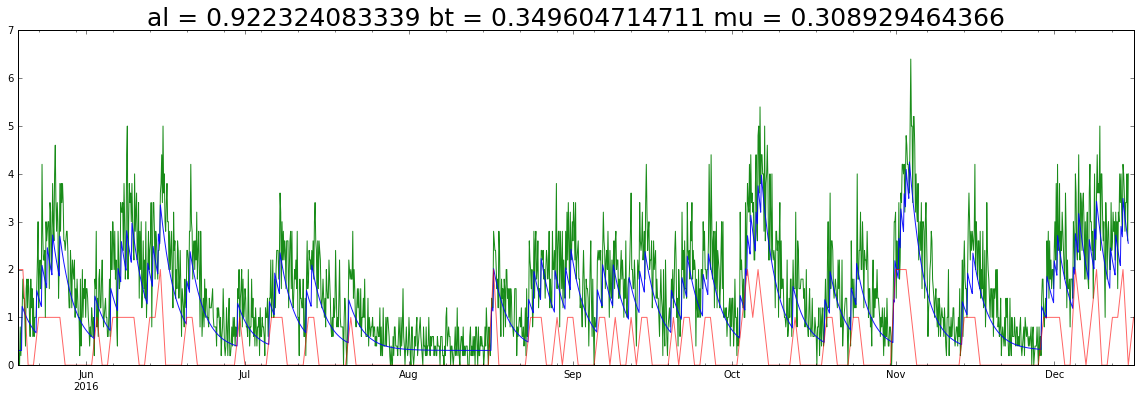

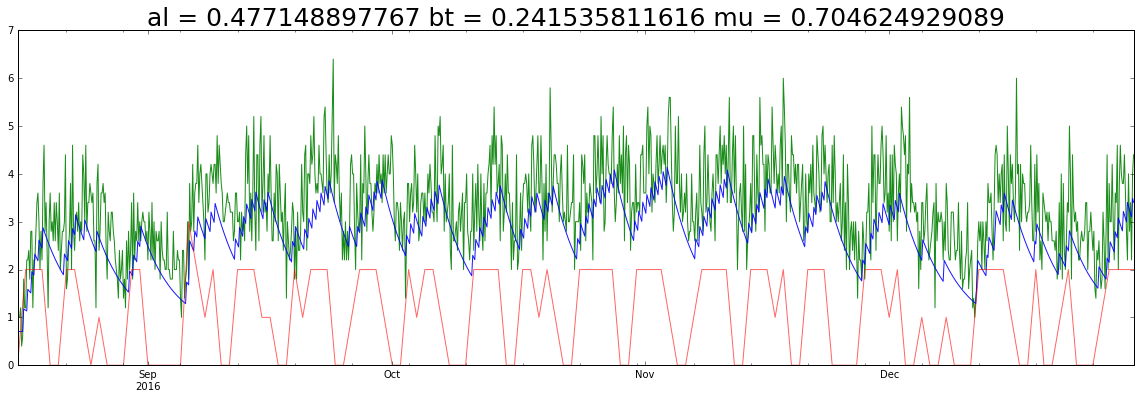

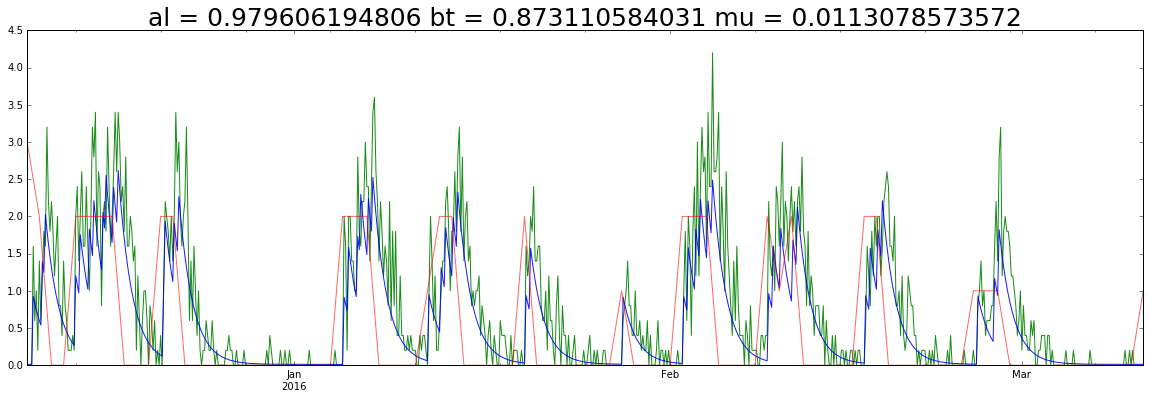

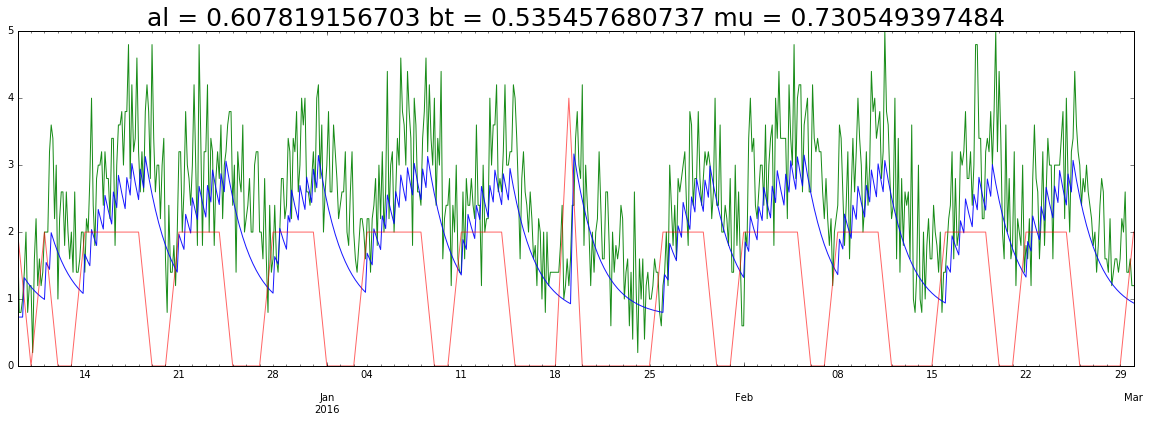

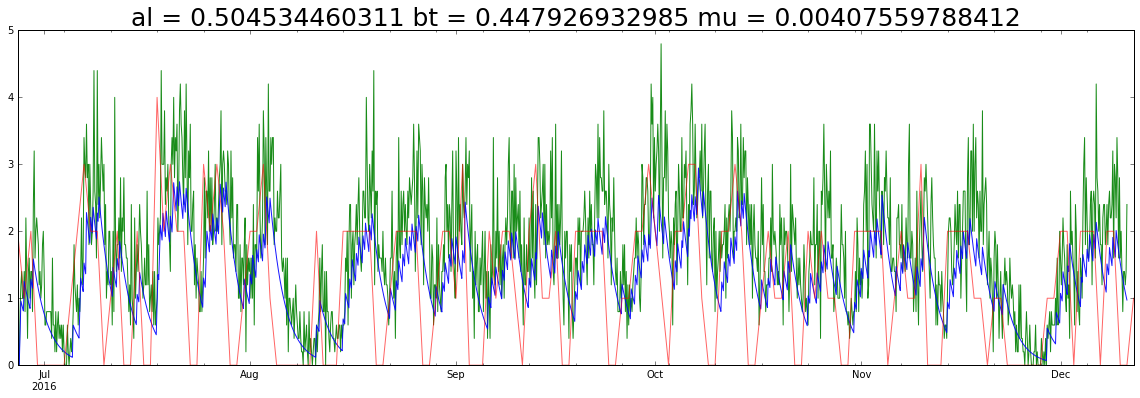

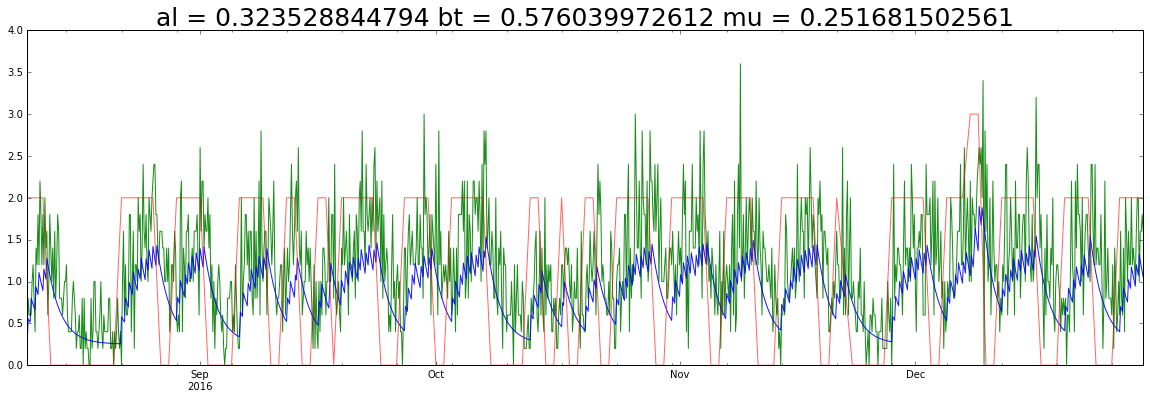

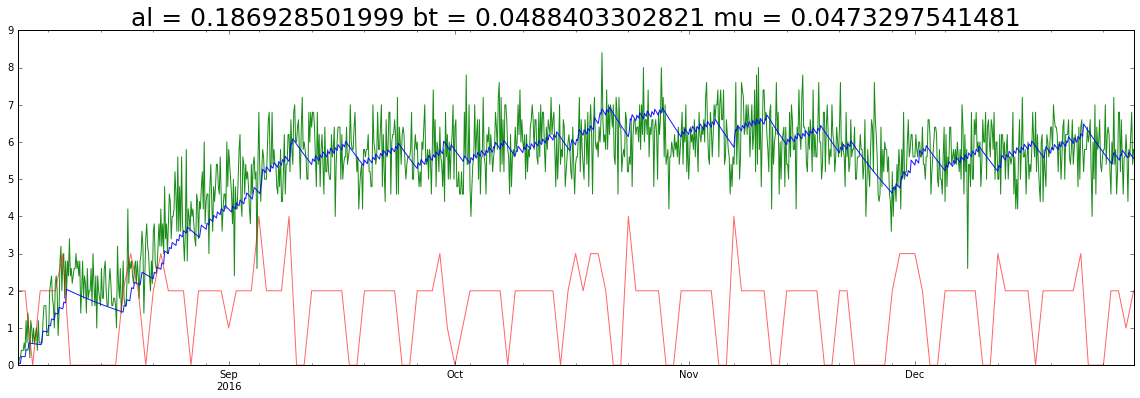

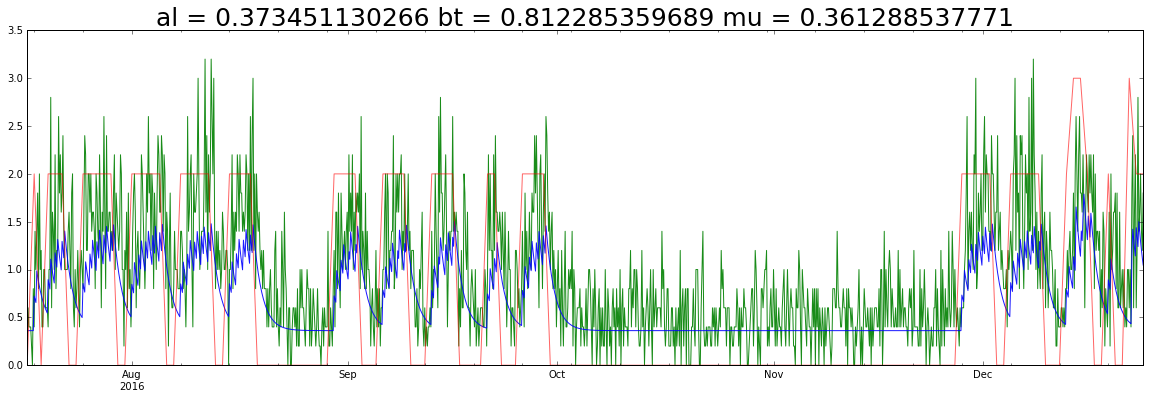

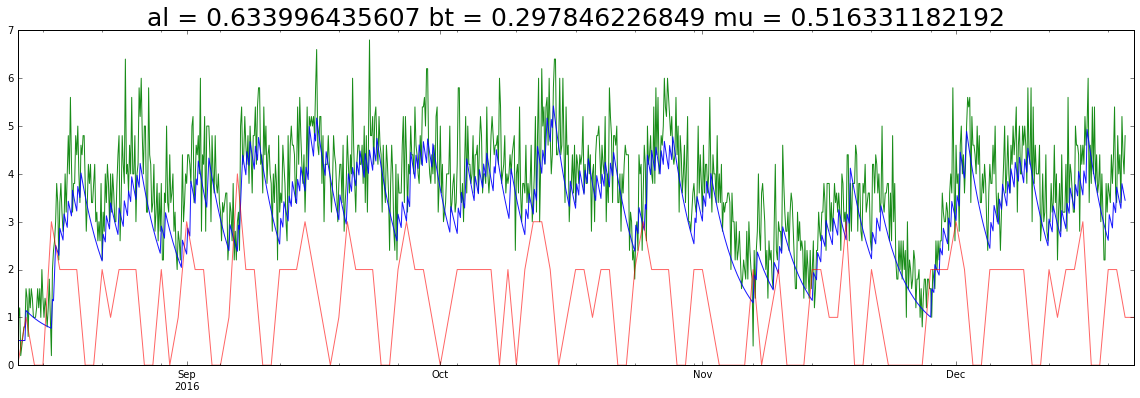

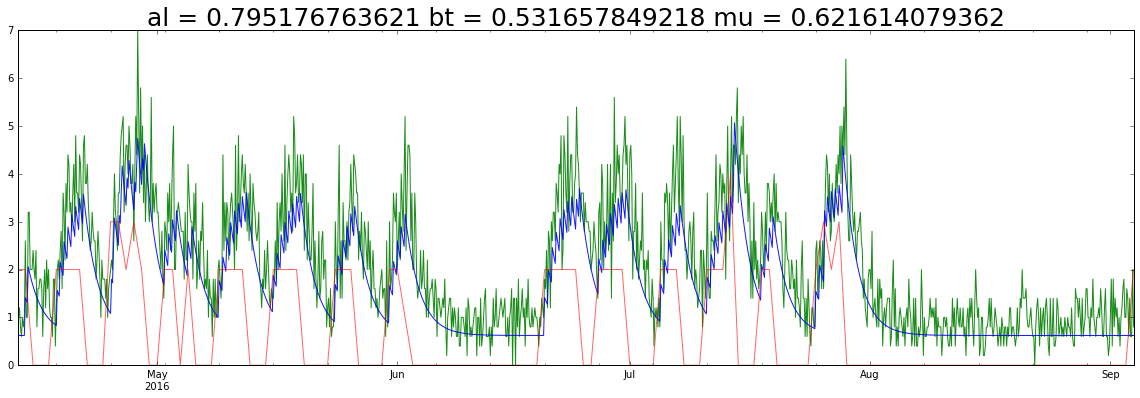

In [7]:
%%time
_key=list(user_params.keys())[1]
for _key in user_params.keys():
    empcnts,cond_int=_pltusr(user_params[_key],_key,step='D')

(2.0, array([ 0.01130786]))
(0.0, array([ 1.00885354]))
(2.0, array([ 0.4279332]))
(0.0, array([ 1.20832769]))
(0.0, array([ 0.51124366]))
(0.0, array([ 0.22010624]))
(0.0, array([ 0.09851258]))
(2.0, array([ 0.04772894]))
(0.0, array([ 1.03478353]))
(0.0, array([ 0.43876287]))
(0.0, array([ 0.18983461]))
(0.0, array([ 0.08586963]))
(0.0, array([ 0.04244861]))
(0.0, array([ 0.0243138]))
(0.0, array([ 0.0167398]))
(2.0, array([ 0.01357651]))
(0.0, array([ 0.99744089]))
(2.0, array([ 0.4231667]))
(0.0, array([ 1.39820397]))
(0.0, array([ 0.59054556]))
(0.0, array([ 0.25322671]))
(2.0, array([ 0.11234536]))
(0.0, array([ 1.05808]))
(0.0, array([ 0.44849265]))
(0.0, array([ 0.19389826]))
(0.0, array([ 0.08756681]))
(0.0, array([ 0.04315744]))
(0.0, array([ 0.02460985]))
(0.0, array([ 0.01686344]))
(0.0, array([ 0.01362815]))
(2.0, array([ 0.01227693]))
(0.0, array([ 1.02467192]))
(0.0, array([ 0.43453975]))
(0.0, array([ 0.18807082]))
(0.0, array([ 0.08513298]))
(0.0, array([ 0.04214095]))

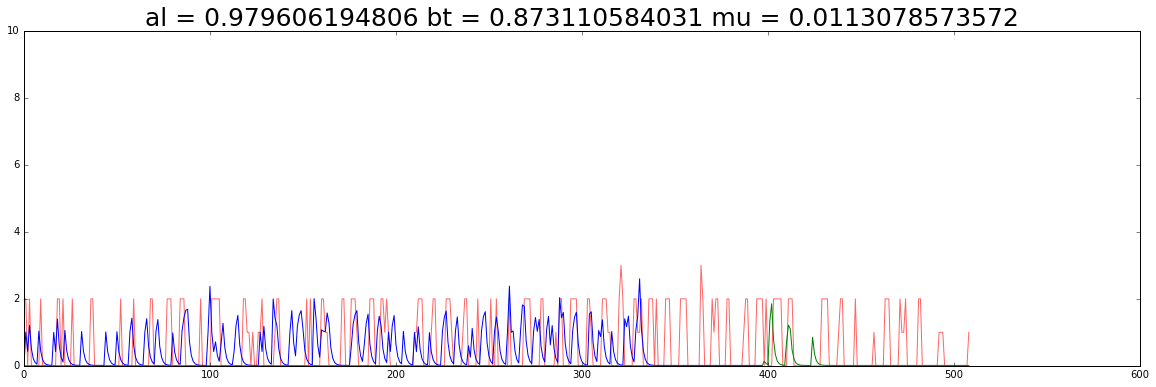

In [54]:
dtw=plot_users(user_params[list(user_params.keys())[0]])

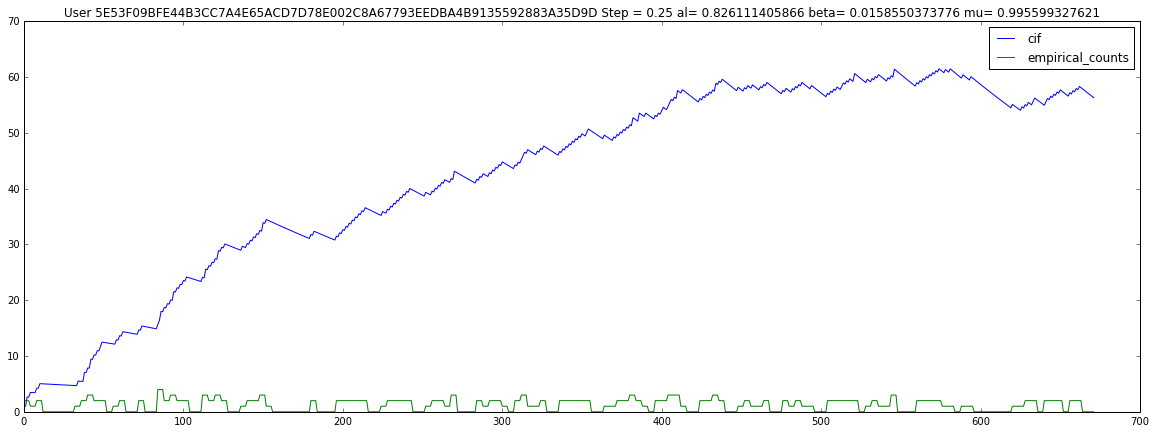

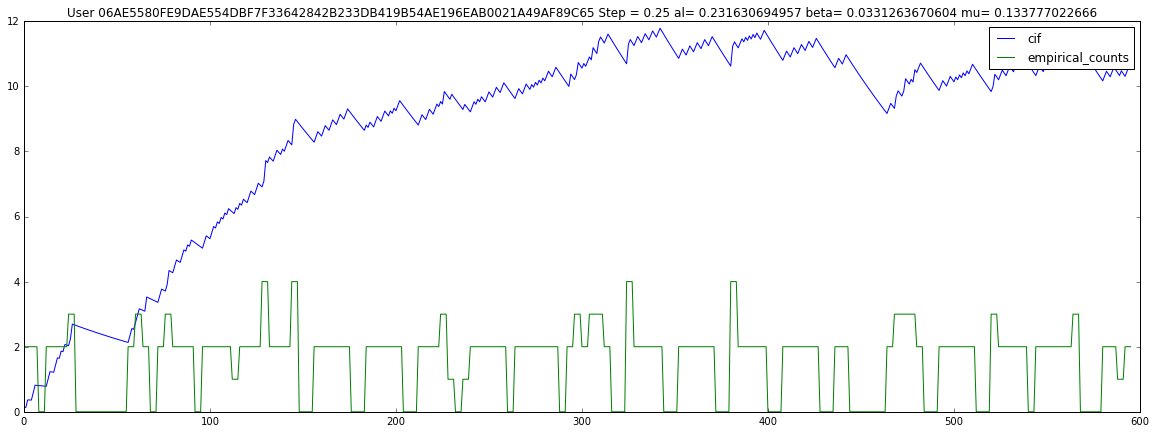

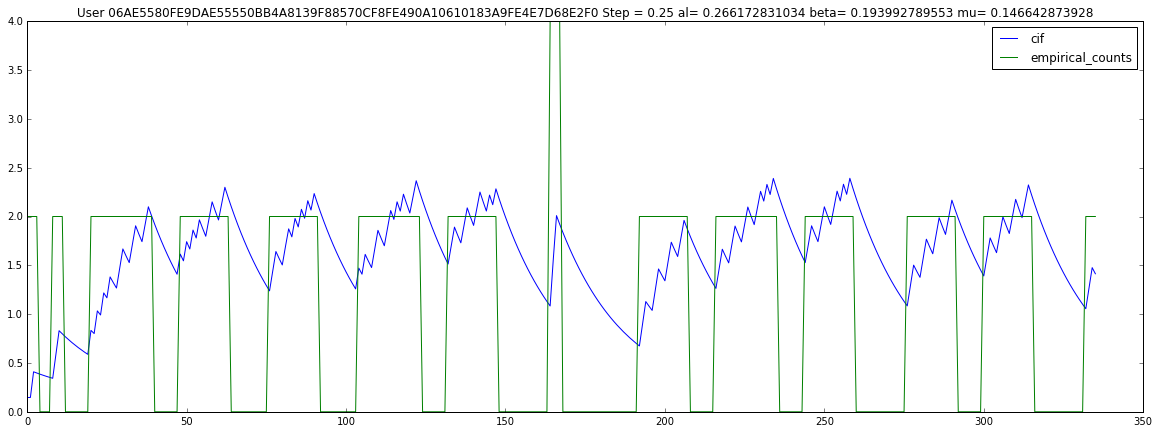

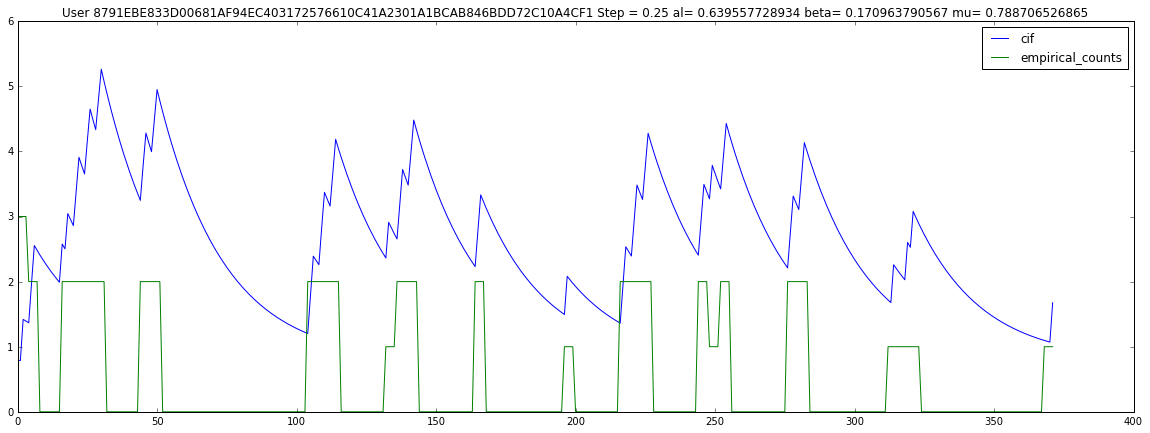

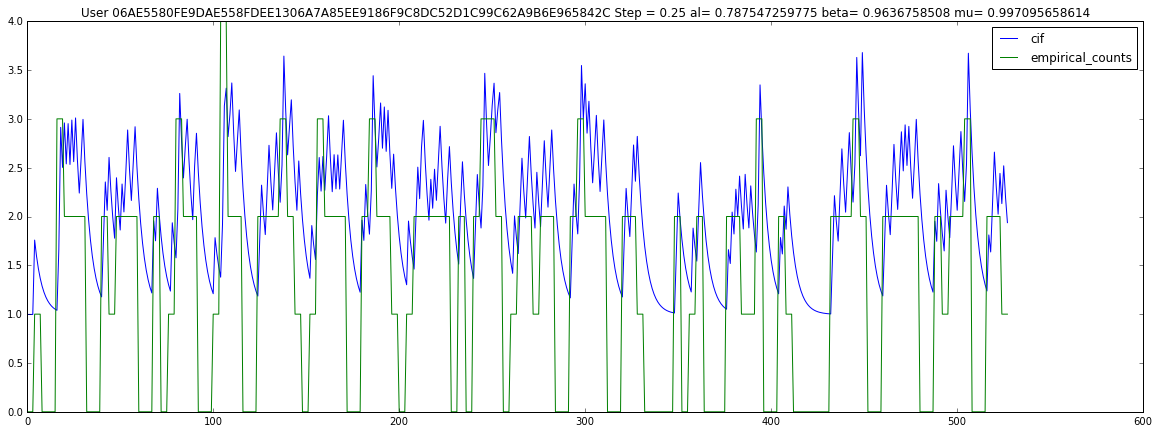

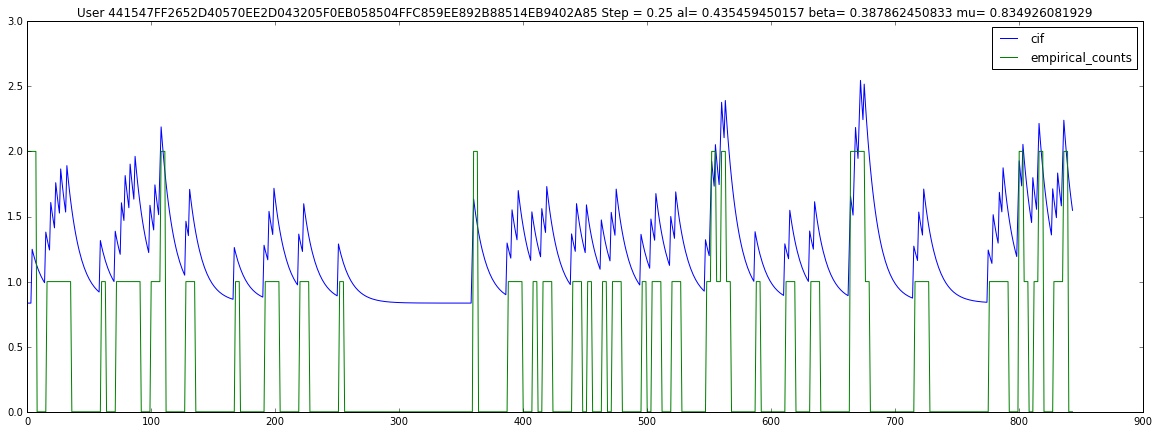

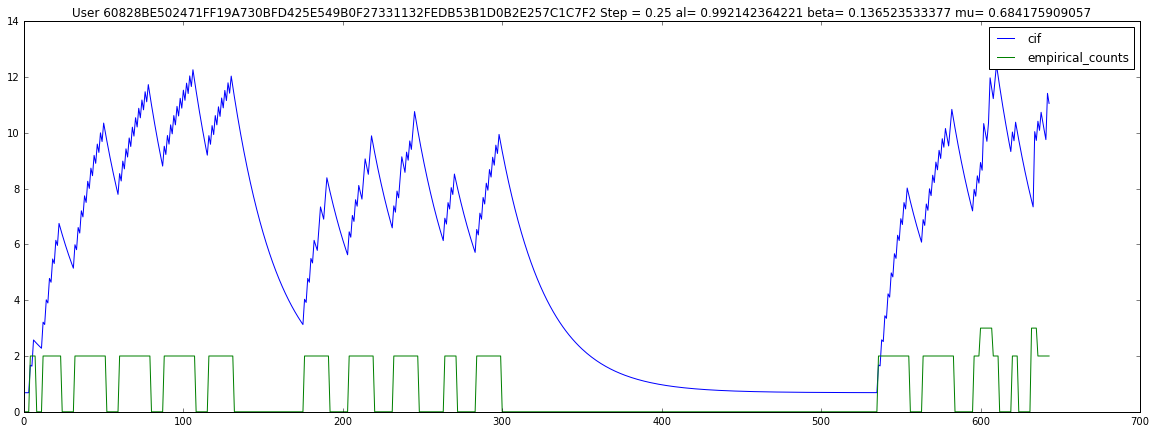

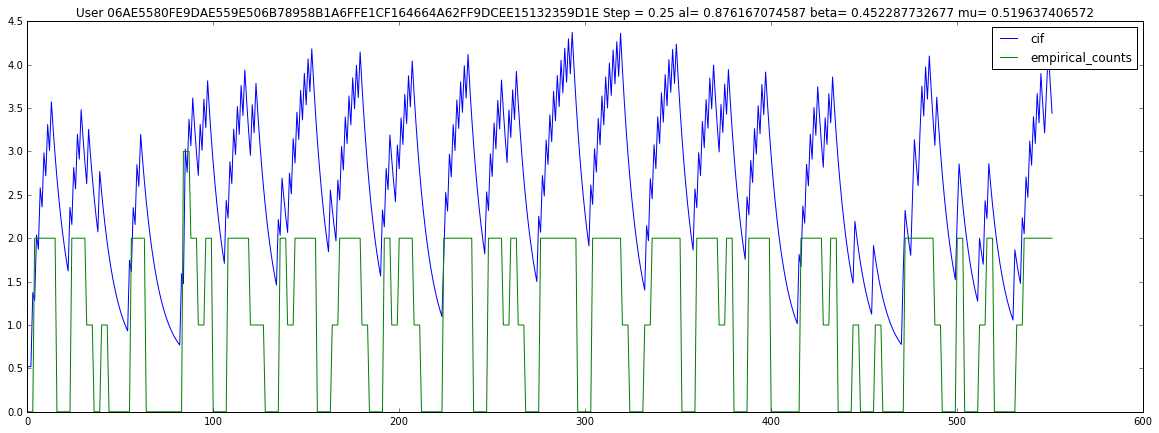

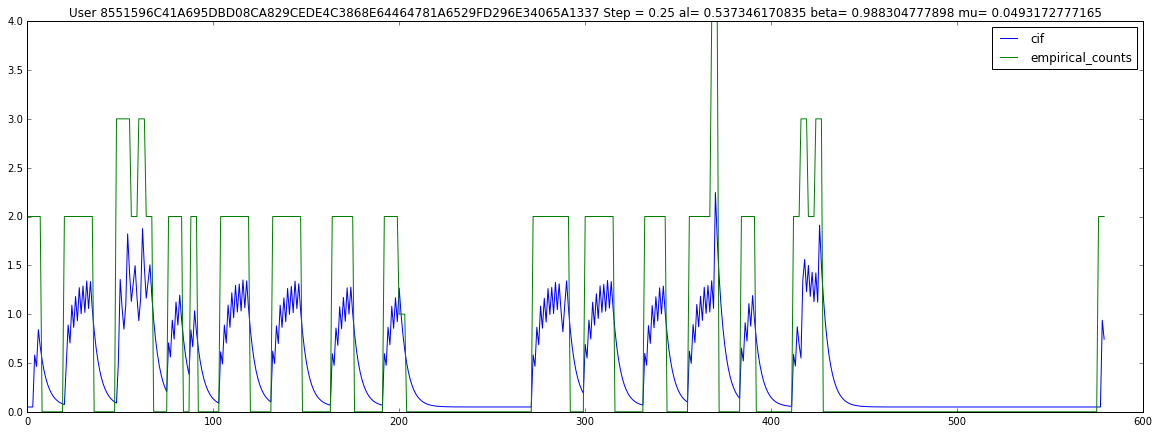

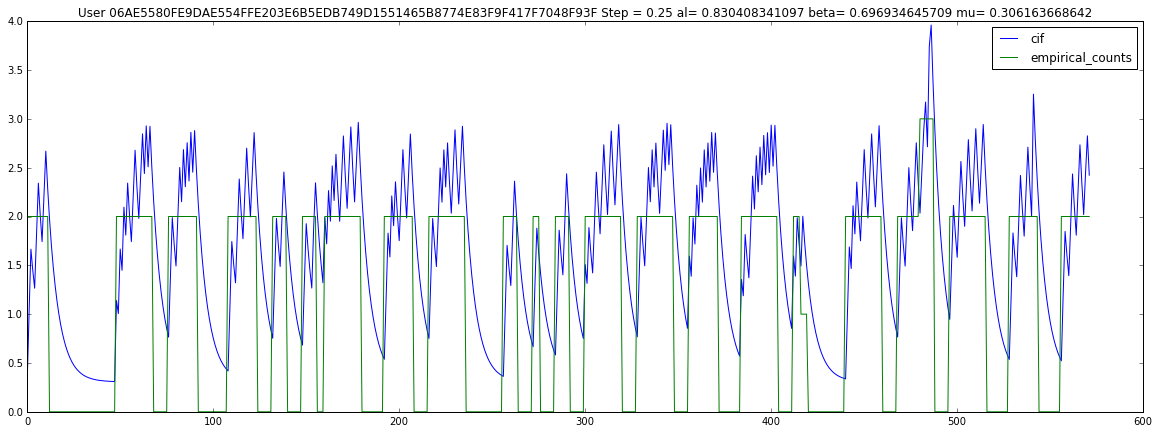

In [66]:
plot_users(step=0.25)

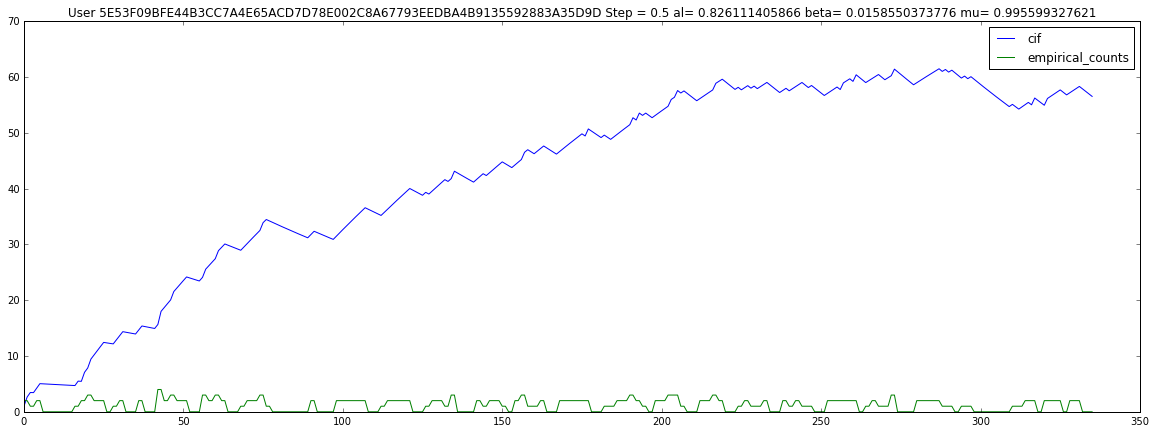

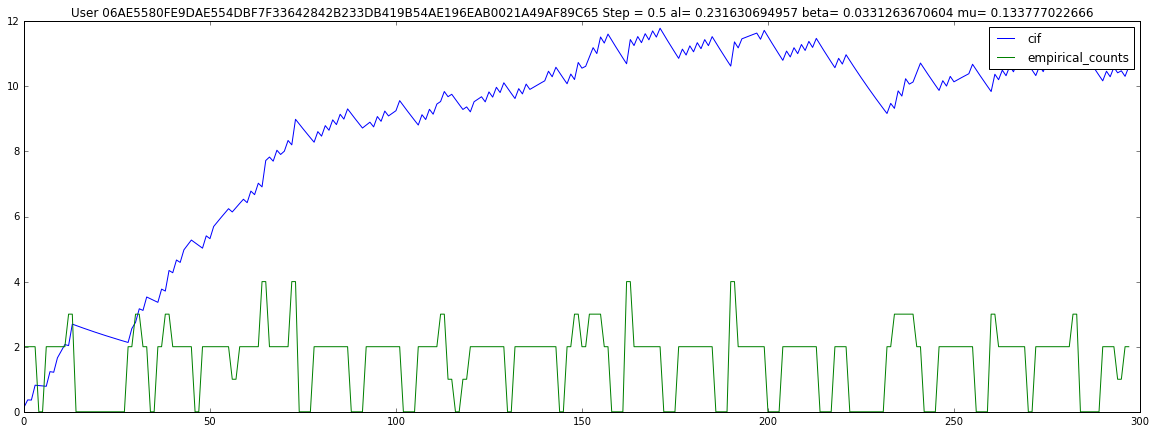

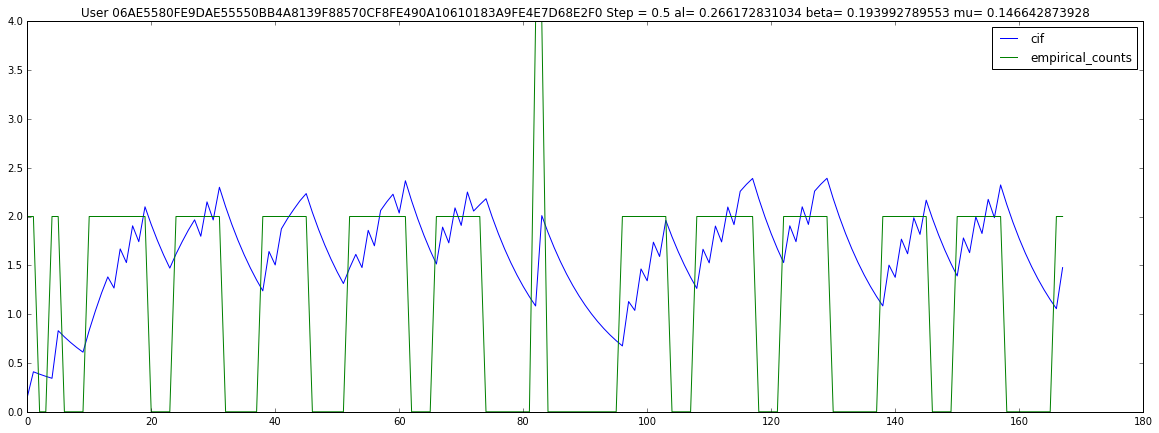

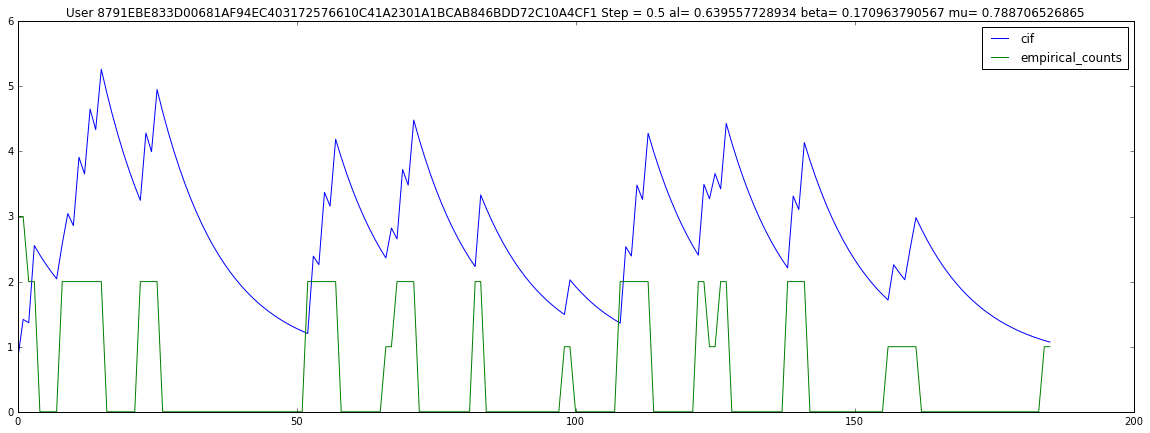

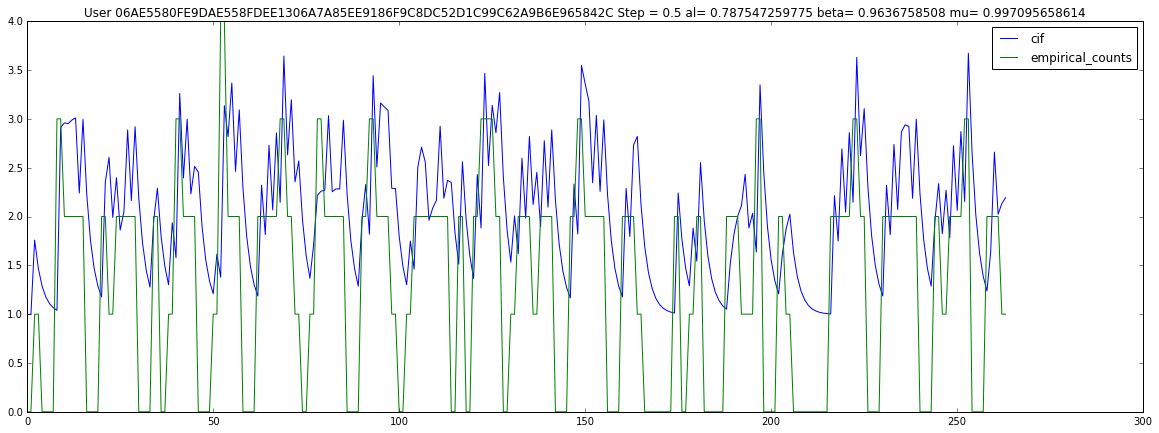

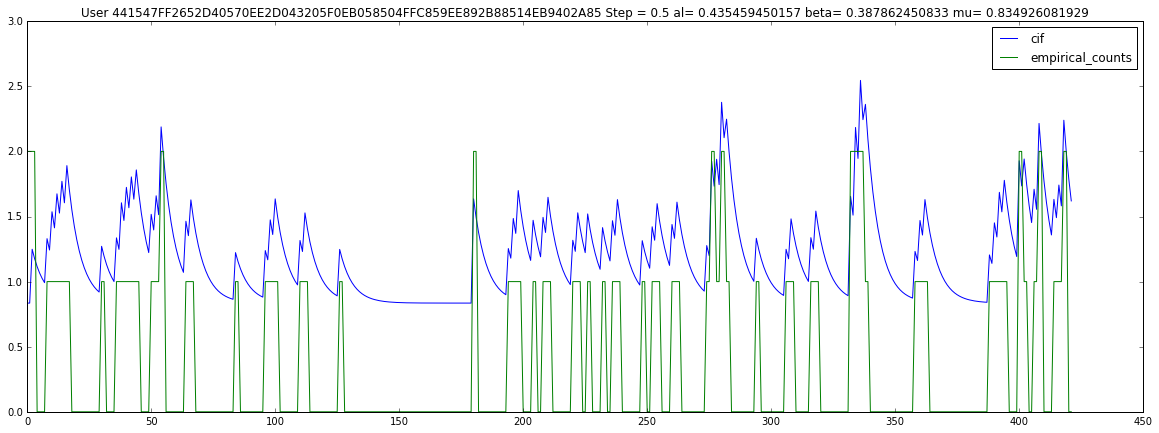

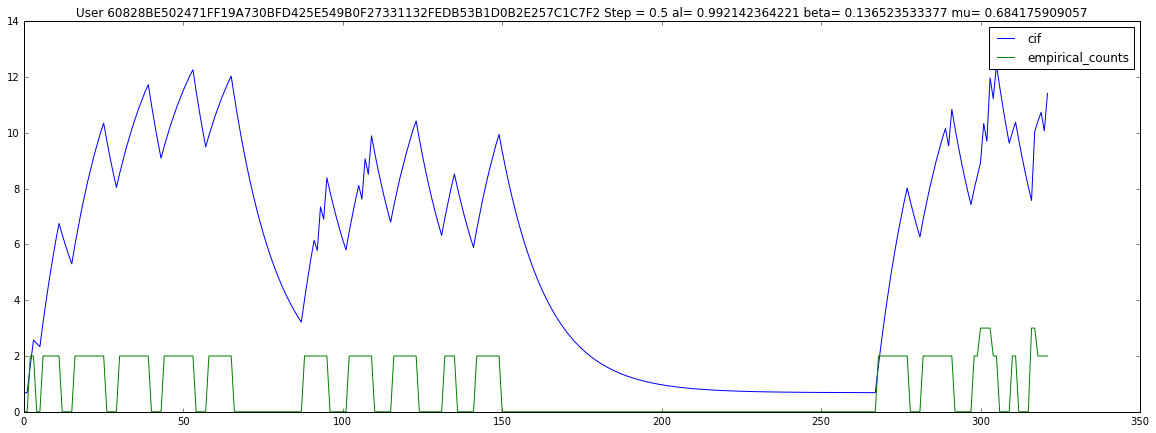

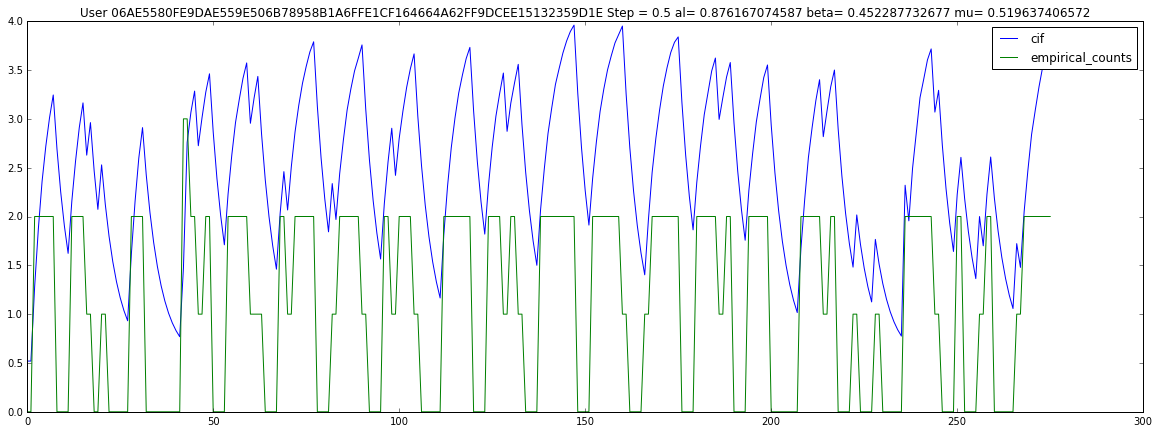

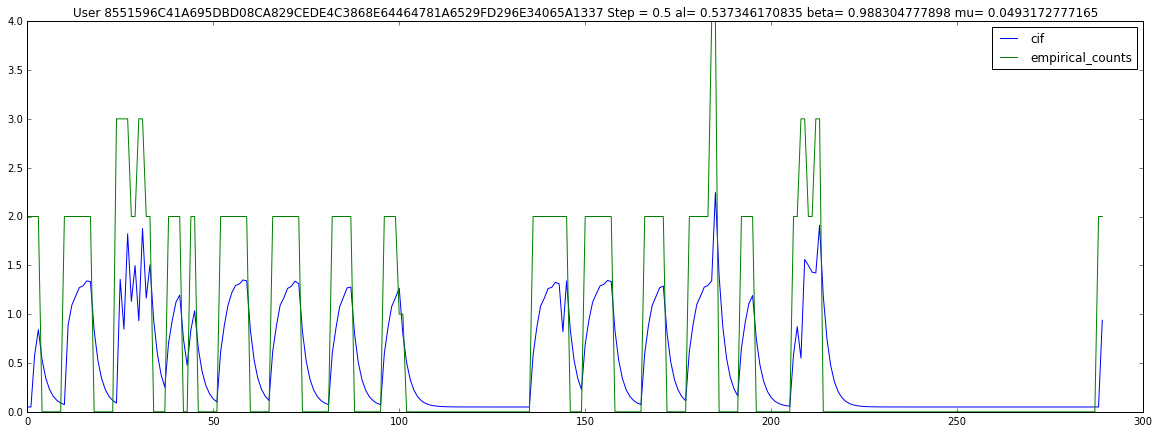

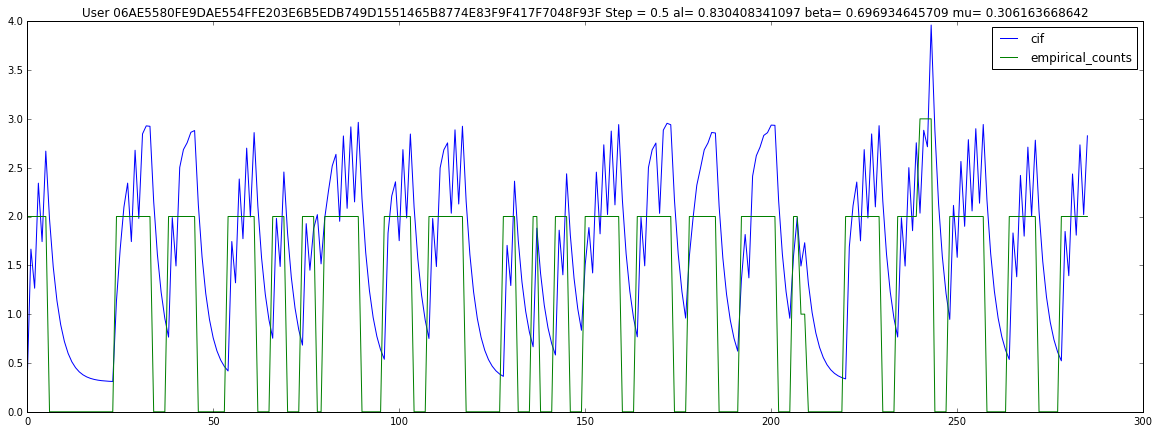

In [67]:
plot_users(step=0.5)

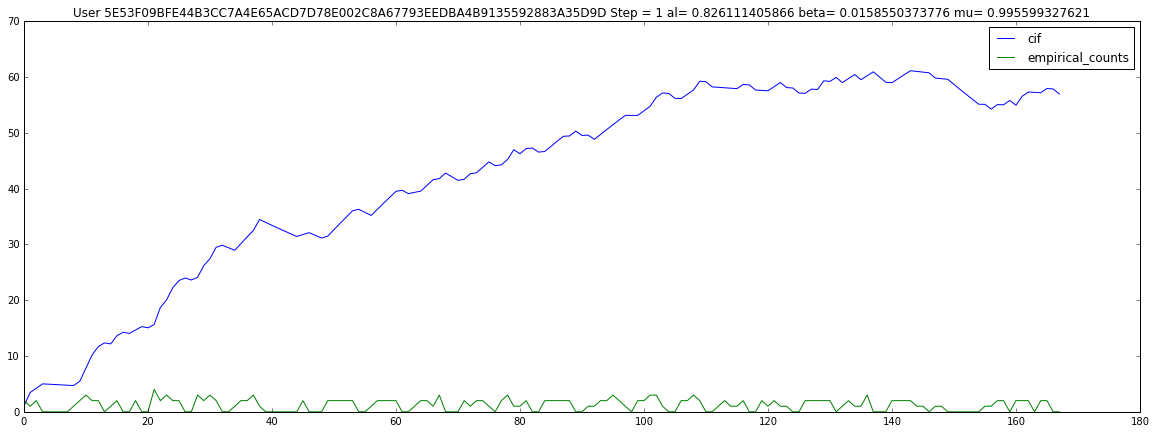

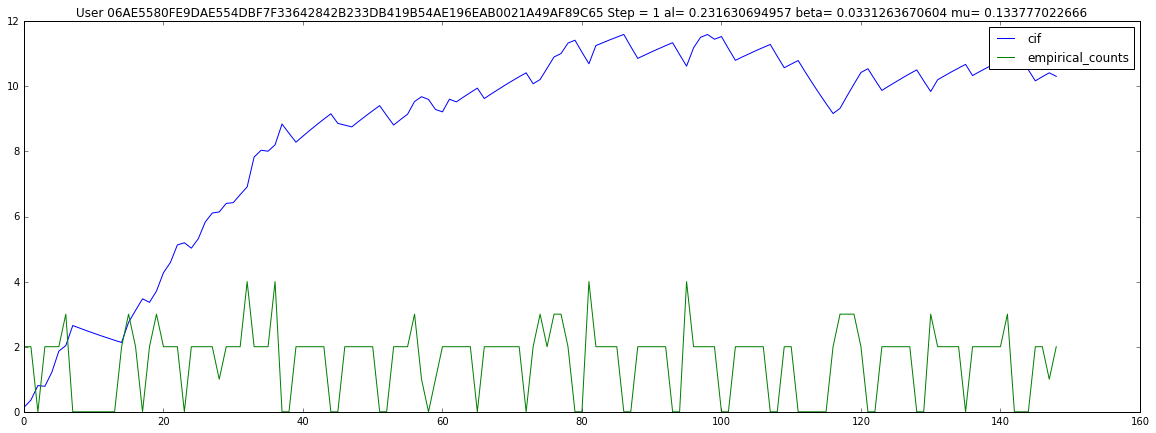

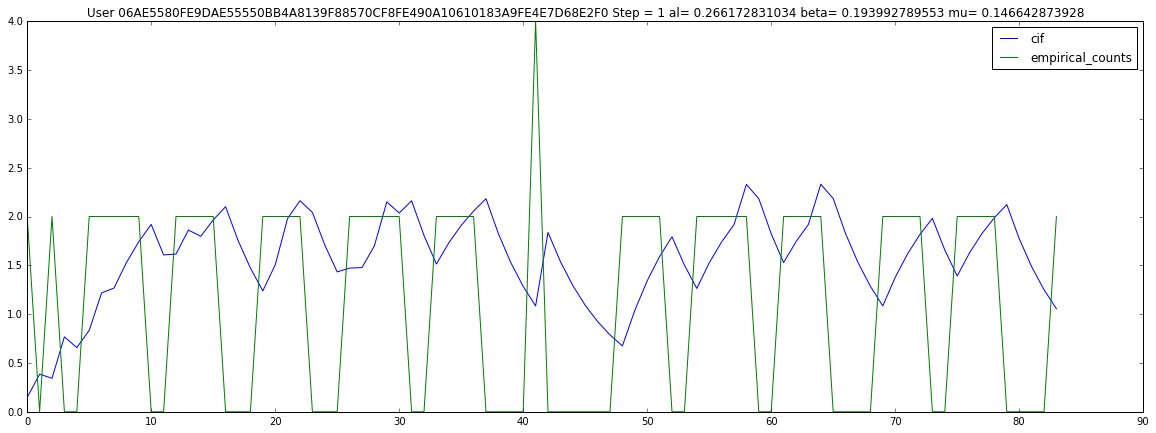

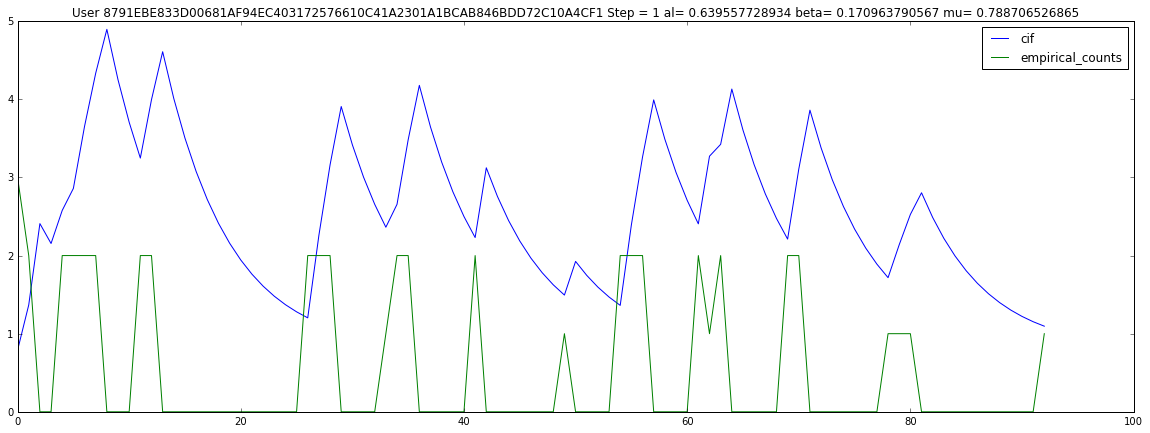

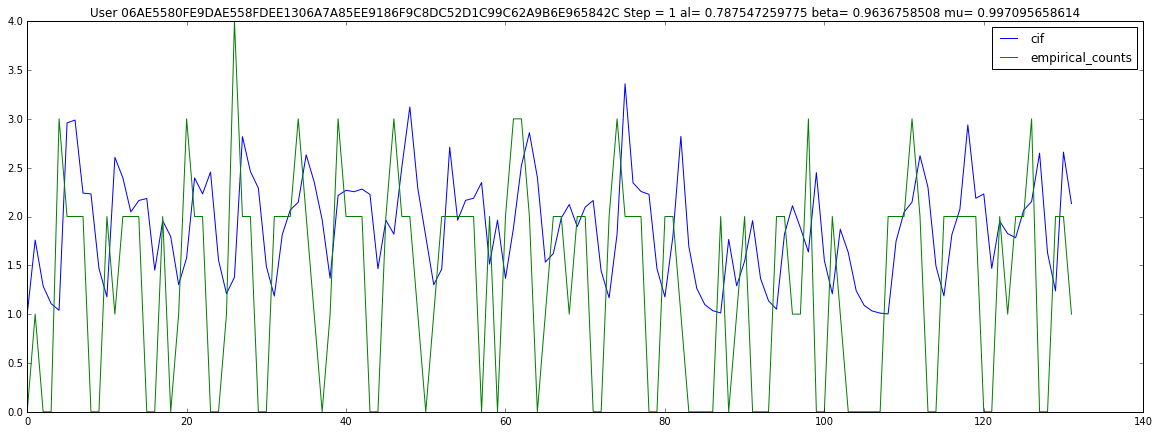

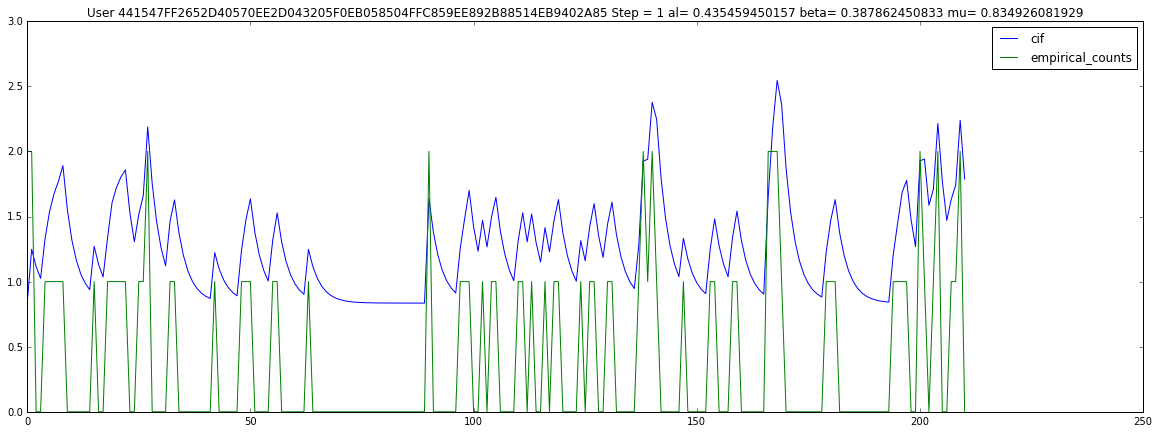

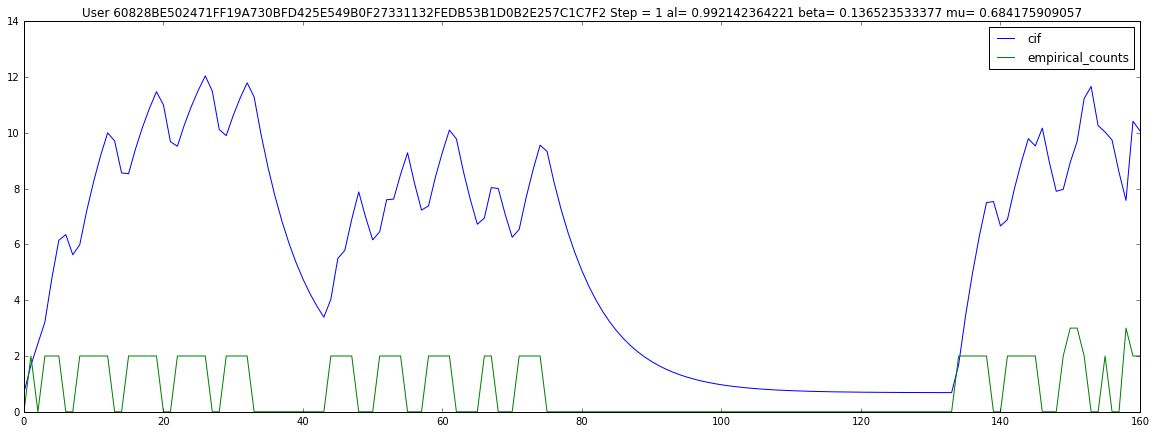

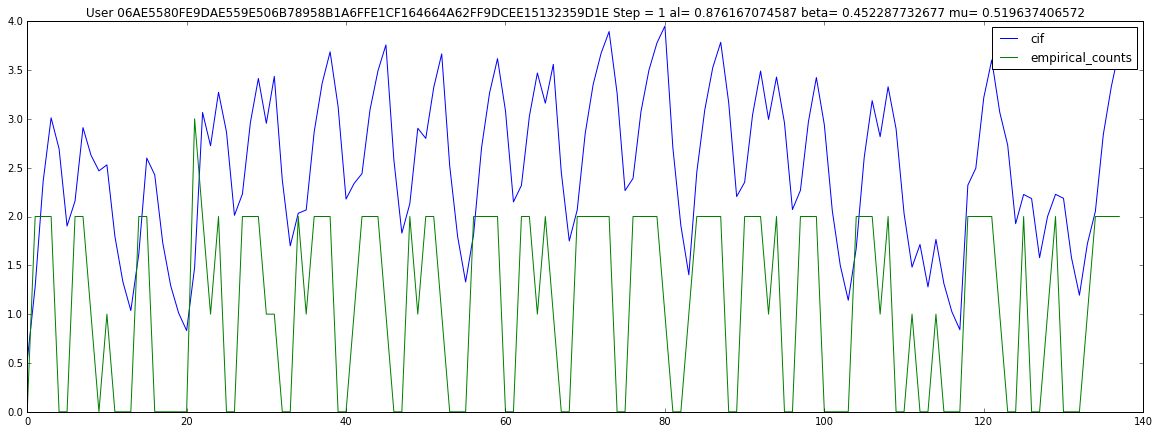

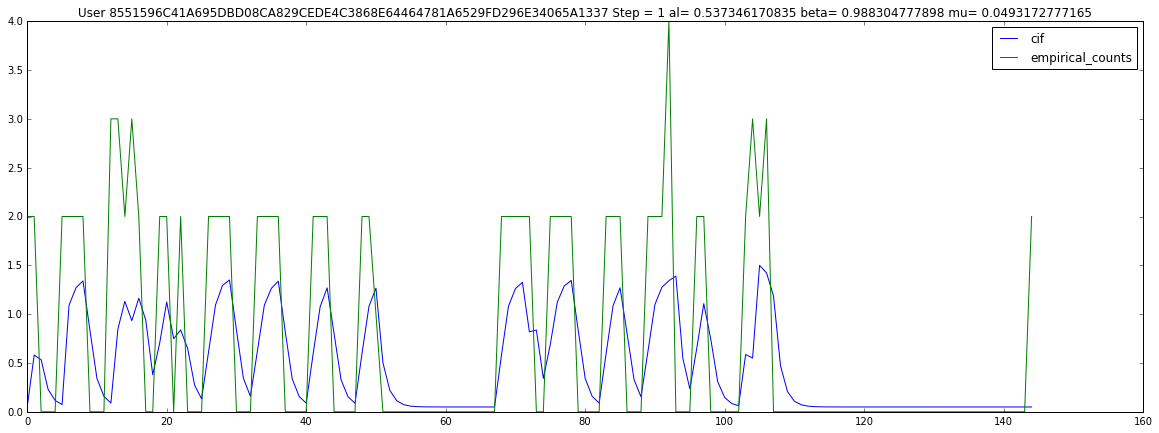

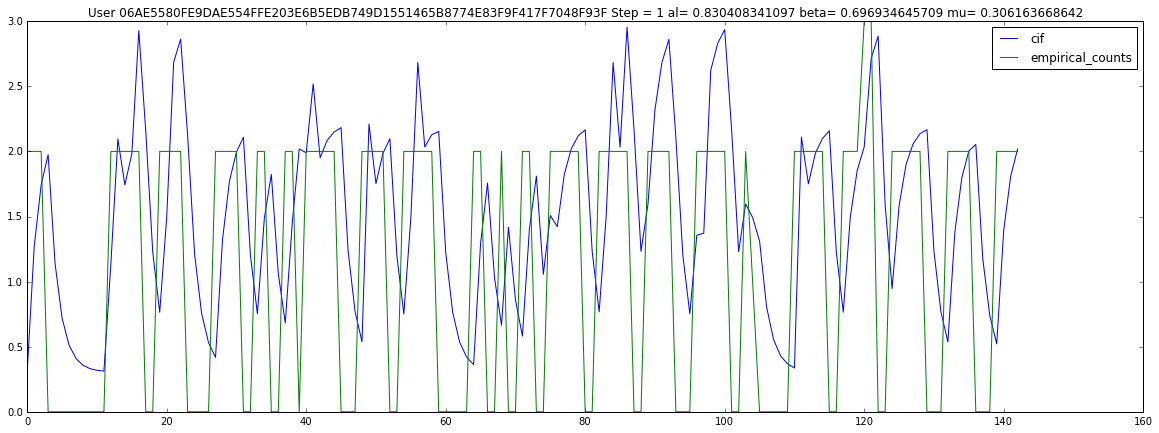

In [49]:
plot_users(step=1)